In [160]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import cvxpy as cp
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

abspath = os.path.abspath(os.getcwd())
finpath = Path(abspath).resolve().parent
parent_path = str(finpath) + '/'

final_df = pd.read_csv(parent_path + "FinalDF.csv")
adj_counties = pd.read_csv(parent_path + "AdjacentDelta.csv")
final_df["Population"] = np.sqrt(final_df["Population"]) / np.sqrt(final_df["Population"].max()) #Ask about specific transformation for weighting to use here

In [128]:
def standardize_df(df):
    df = df.select_dtypes(exclude=['object'])
    feature_cols = df.columns[2:]
    std_final_df = pd.DataFrame(StandardScaler().fit_transform(df.iloc[:, 2:]), columns=feature_cols)
    pop_df = df["Population"]
    return std_final_df, pop_df

def shuffle_data(data, labels, p):
    indices = np.random.permutation(len(data))
    return data[indices], labels[indices], p[indices]

def split_data(data, labels, p):
    size = len(data)
    index_eighty = int(size*0.8)
    train_data = data[:index_eighty]
    train_labels = labels[:index_eighty]
    train_p = p[:index_eighty]
    test_data = data[index_eighty:]
    test_labels = labels[index_eighty:]
    test_p = p[index_eighty:]
    return train_data, train_labels, train_p, test_data, test_labels, test_p

In [129]:
median_income = final_df["Median Household Income"].median()
df_upper_income = final_df[final_df["Median Household Income"] >= median_income]
df_lower_income = final_df[final_df["Median Household Income"] < median_income]
#print(df_upper_income["Population"])
#print(df_lower_income.shape)

# Here, our dataframes are not the same shapes because % Completed High School has many values at the median,
# but the number of observations in the dataframes are 1197 for the upper bracket and 1209 for the lower bracket,
# which we found to be acceptable for running our regression analysis on
median_edu = final_df["% Completed High School"].median()
df_upper_edu = final_df[final_df["% Completed High School"] > median_edu]
df_lower_edu = final_df[final_df["% Completed High School"] <= median_edu]

# Adjacent counties regression

adj_counties = adj_counties.select_dtypes(exclude=['object'])


# Standardizing values and creating all the matrices we need to run Lasso

df_lst = [final_df, df_upper_income, df_lower_income, df_upper_edu, df_lower_edu] #Want to add adj_counties to this list after Population column is added
params_lst = []
for frame in df_lst:
    std_frame, pop_df = standardize_df(frame)
    label_df = std_frame["% Smokers"]
    IV_df = std_frame["Cig Tax Rate"]
    features_df = std_frame.drop(columns=["% Smokers", "Cig Tax Rate"])
    p = np.array([pop_df]).T
    X = np.array(features_df)
    IV = np.array([IV_df]).T
    y = np.array([label_df]).T
    values = [X, IV, y, p]
    params_lst.append(values)
    print(p.shape)
    print(X.shape)
    print(IV.shape)

(2406, 1)
(2406, 48)
(2406, 1)
(1203, 1)
(1203, 48)
(1203, 1)
(1203, 1)
(1203, 48)
(1203, 1)
(1197, 1)
(1197, 48)
(1197, 1)
(1209, 1)
(1209, 48)
(1209, 1)


In [131]:
def cross_validation(params, lower, upper, lambdas, folds):
    X, IV, y, p = params
    lams = np.linspace(lower, upper, lambdas)
    error_lst = []
    gen_params_lst = []
    min_error = 100000000
    best_lam = None
    for _ in range(folds):
        X_s, y_s, p_s = shuffle_data(X, y, p)
        gen_params = split_data(X_s, y_s, p_s)
        gen_params_lst.append(gen_params)
    for lam in lams:
        sum_error = 0
        for gen_params in gen_params_lst:
            train_X, train_y, train_p, test_X, test_y, test_p = gen_params
            B = cp.Variable((train_X.shape[1], 1))
            objective = cp.Minimize((train_p.T @ (train_y - train_X @ B) ** 2) + lam * cp.norm1(B))
            constraints = []
            prob = cp.Problem(objective, constraints)
            prob.solve()
            betas = np.array(B.value)
            error = (test_p.T @ ((test_y - test_X @ betas) ** 2))
            sum_error += float(error)
        if sum_error < min_error:
            min_error = sum_error
            best_lam = lam
        error_lst.append(sum_error)
    print(best_lam)
    plt.plot(lams, error_lst)
    plt.show()


0.11111111111111112


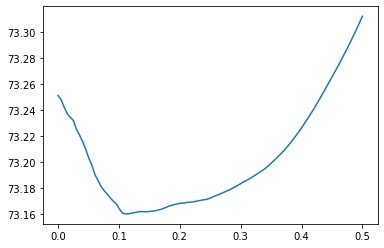

In [132]:
cross_validation(params_lst[0], 0, 0.5, 100, 20)

0.9191919191919192


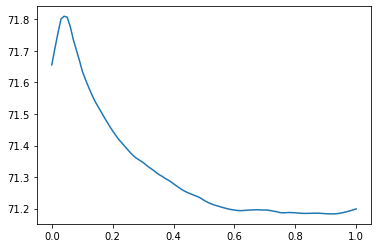

In [135]:
cross_validation(params_lst[1], 0.0, 1, 100, 20)

0.08080808080808081


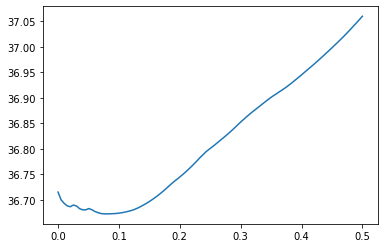

In [157]:
cross_validation(params_lst[2], 0.0, 0.5, 100, 20)

0.4040404040404041


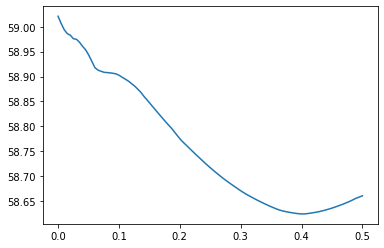

In [158]:
cross_validation(params_lst[3], 0.0, 0.5, 100, 20)

0.6262626262626263


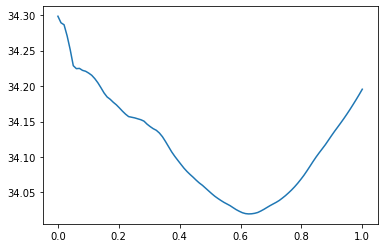

In [159]:
cross_validation(params_lst[4], 0.0, 1, 100, 20)

In [161]:
def cross_validation2(params, lower, upper, lambdas, folds):
    X, IV, y, p = params
    lams = np.linspace(lower, upper, lambdas)
    error_lst = []
    gen_params_lst = []
    min_error = 100000000
    best_lam = None
    for _ in range(folds):
        IV_s, y_s, p_s = shuffle_data(IV, y, p)
        gen_params = split_data(IV_s, y_s, p_s)
        gen_params_lst.append(gen_params)
    for lam in lams:
        sum_error = 0
        for gen_params in gen_params_lst:
            train_IV, train_y, train_p, test_IV, test_y, test_p = gen_params
            B = cp.Variable((train_X.shape[1], 1))
            objective = cp.Minimize((train_p.T @ (train_y - train_IV @ B) ** 2) + lam * cp.norm1(B))
            constraints = []
            prob = cp.Problem(objective, constraints)
            prob.solve()
            betas = np.array(B.value)
            error = (test_p.T @ ((test_y - test_IV @ betas) ** 2))
            sum_error += float(error)
        if sum_error < min_error:
            min_error = sum_error
            best_lam = lam
        error_lst.append(sum_error)
    print(best_lam)
    plt.plot(lams, error_lst)
    plt.show()


0.11111111111111112


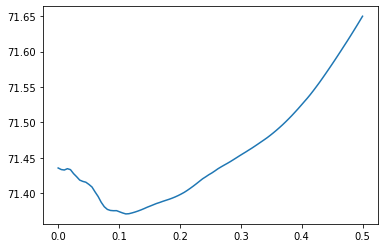

In [163]:
cross_validation(params_lst[0], 0.0, 0.5, 100, 20)

0.32323232323232326


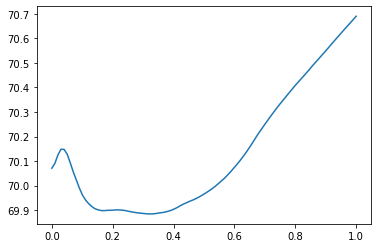

In [164]:
cross_validation(params_lst[1], 0.0, 1, 100, 20)

0.10606060606060606


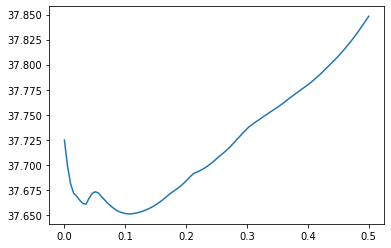

In [165]:
cross_validation(params_lst[2], 0.0, 0.5, 100, 20)

0.4545454545454546


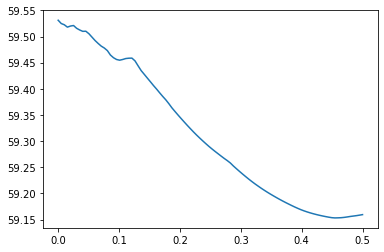

In [166]:
cross_validation(params_lst[3], 0.0, 0.5, 100, 20)

0.08080808080808081


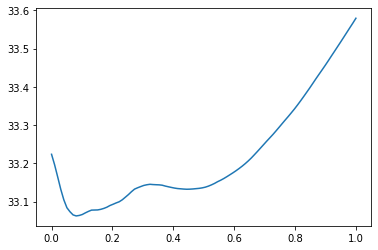

In [167]:
cross_validation(params_lst[4], 0.0, 1, 100, 20)

In [ ]:
def lasso_IV(lambda_IV, params):
    X, y, IV, p = params
    B = cp.Variable((X.shape[1], 1))
    objective = cp.Minimize(p.T @ ((IV - X @ B) ** 2) + lambda_IV * cp.norm1(B))
    constraints = []
    prob = cp.Problem(objective, constraints)
    prob.solve()
    betas_IV = np.array(B.value)
    return betas_IV

def lasso_y(lambda_y, params):
    X, y, IV, p = params
    B = cp.Variable((X.shape[1], 1))
    objective = cp.Minimize(p.T @ ((y - X @ B) ** 2) + lambda_y * cp.norm1(B))
    constraints = []
    prob = cp.Problem(objective, constraints)
    prob.solve()
    betas_y = np.array(B.value)
    return betas_y

def OLS(betas_IV, betas_y, params):
    X, y, IV, p = params
    betas = abs(betas_y) + abs(betas_IV)
    covariates = (betas >= 10 ** -3)
    X_cov = np.concatenate(IV, X[:, covariates],axis=1)
    B = cp.Variable((X.shape[1], 1))
    objective = cp.Minimize(p.T @ ((y - X @ B) ** 2))
    constraints = []
    prob = cp.Problem(objective, constraints)
    prob.solve()
    betas = np.array(B.value)
    return betas

def double_lasso(lambda_IV, lambda_y, params):
    betas_IV = lasso_IV(lambda_IV, params)
    betas_y = lasso_y(lambda_y, params)
    betas = OLS(betas_IV, betas_y, params)
    return betas
    
    

In [156]:
a = np.array([[0,3,4,5,2],[3,2,4,3,1]])
b = np.array([False, True, False, False, True])
c = np.array([[1],[2]])
print(a[:, b])
print(np.concatenate((a[:, b], c),axis=1))

[[3 2]
 [2 1]]
[[3 2 1]
 [2 1 2]]
